# <center> Implementation of Scalable K-Means++ in Python<center>

 <center>Final Project<center> 
 <center> STA 663: Statistical Computation <center> 
 <center> Susan Cherry and Arpita Mandan<center> 
  <center> www.github.com/susancherry/Statistical_Computation <center> 

### <center> Abstract <center>
<center> We implement the *kmeans||* algorithm that is introduced in "Scalable K-Means++", which is a parallel version of the *kmeans++*. The algorithm is implemented in Python and optimzed with JIT and Cython. We also create a parallel version. We then test the functions on three different datasets: a synthetic gaussian mixture dataset, the iris dataset, and the UCI Machine Learning repository breast cancer dataset. We concluse that *kmeans||* is a fast algorithm that significantly reduces initialization costs when compared to random initialization of centers and *kmeans++*. More work should be done to improve our parallel implementation and to test the functions are datasets with large numbers of clusters <center>


### Section 1: Background
Among clustering algorithms, *k-means* is perhaps the most widely used and studied. Its popularity comes from its simplicity. First, the centers of *k* clusters are randomly initialized. Then each datapoint is assigned to the nearest center. The centers are then recalculated as a result of the new cluster assignments. This local search process (called Lloyd's iteration) is repeated until the *k* center locations do not change between two consecutive iterations. Despite its popularity, *k-means* does have some drawbacks. Its worst case running time is exponential and there is no guarantee that its solution is globally optimal. 

Recent work has tried to improve the algorithm by creating a better initialization procedure. Ostrovsky et al. and Aurther and Vassilvitskii developed an improved algorithm named *k-means++* that selects only the first cluster center at random. The remaining cluster centers are selected with a probability that is proportional to its contribution to the overall error given by the previous center selections. It can be shown that *k-means++* leads to an O(log*k*) approximation of the optimum. Unfortunately, *k-means++* also has some drawbacks. Its initialization is sequential, making it unparallelizable. As datasets grow, the computational time for *k-means++* also grows quickly since a naive implementation of the algorithm makes *k* passes over the data to initialize the centers. 

"Scalable K-Means++" introduces a parallel version of *k-means++* called *k-means||*. Instead of sampling a single point at each iteration of the algorithm, the authors suggest sampling O(*k*) points in each round and repeating this for roughly O(log *n*) rounds. At the end of the algorithm, there are O(*k* log *n*) points. These points are reclustered into *k* initial centers for Lloyd's iteration.  The authors of "Scalable K-Means++" test *k-means||* on real datasets and make the following observations:
* In as little as 5 rounds, the *k-means||* solultion is consistently as good as other *k-means* methods. 
* The parallel implementation of *k-means||* is much faster than existing parallel algorithms for *k-means*.
* The number of iterations until Lloyd's algorithm converges is smallest when using *k-means||*. 

In this paper, we will implement the *k-means||* algorithm and test it on several datasets. We find that when parallelized, it is faster than the *k-means++* algorithm and also achieves the lowest cost among *k-means||*, *k-means++*, and random initialization.   

### Section 2: Algorithm Description
This section provides a description of the *k-means||* algorithm and follows the information and notation presented in "Scalable K-Means++" quite closely. First, we introduce notation and formally present the *k-means* algorithm. Then we breifly discuss the intution behind *k-means||*. Finally, we present *k-means||* and state the formal guarantee of the algorithm. 

#### 2.1: Notation, K-Means, and K-Means++
Let $X$={$x_1, x_2,..., x_n$} be a set of datapoints and $k$ be the number of clusters. $||x_i-x_j||$ is the Euclidean distance between $x_i$ and $x_j$. Let $Y\subseteq X$ and $x \in X$. The distance from $x$ to $Y$ is defined as $d(x,Y)=min_{y \in X}||x-y||$. The center of $Y$ is defined by $center(Y)=\frac{1}{|Y|}\sum_{y\in Y} y$.

Next we will define the cost of Y with respect to $C$, where $C$={$c_1,...,c_n$} is a set of points. The cost of $C$ is: $\phi_Y(C)=\sum_{y\in Y} min_{1,...,k} ||y-c_i||^2$. K-means attempts to choose $C$, a set of $k$ centers, such that $\phi_Y(C)$ is minimized. Let $\phi^*$ be the cost of the optimal clustering. A set of $C$ centers is an $\alpha- approximation$ if $\phi_x(C)\leq\alpha \phi^*$. 

The original *k-means* algorithm is as follows: Start with a random initalization of *k* centers. Then the algorithm starts iterations called Lloyd's iterations. During each iteration, a clustering is formed from the current centers. The centers of the new clusters are derived and become the centers for the next iteration. This continues until the centers do not change between two consecutive iterations.

*k-means++* is similar to the algorithm described above, but modifies the initialization process. The centers are chosen one-by-one where the set of centers that have already been chosen stochastically bias the choice of the next center. This is an improvement because even the initialization of the centers obtains and (8 log *k*) approxiation in expection. The drawback, as mentioned earlier, is that it is sequential in nature so it cannot be parallelized.

#### 2.2: K-Means|| Algorithm
First, we will present the intuition behind the *k-means||* algorithm. Random initialization of centers selections $k$ centers in a single iteration according to the uniform distribution. *k-means++* selects one point at each iteration according to a non-uniform distribution. *k-means||* was designed to acheive the "best of both worlds". It is an algorithm to work a just a few iterations but according to a non-uniform distribution.  *k-means||* finds the best trade off between these two goals. 

Next, we formally present the *k-means|| algorithm*. It is nearly identical to *k-means++*, but now includes an oversampling factor $\ell$. The k-means|| algorithm with ($k,\ell$) initialization algorithm is below:

* Step 1: Pick an initial center uniformly at random from $X$.
* Step 2: Compute $\psi=\phi_x(C)$, the inital cost of clustering after Step 1. 

    **For** $O$ log($\psi$) times **do**:
    * Step 3: Calculate $C'$ by sampling each point $x \in X$ independently with probability $p_x=\frac{\ell*d^2(x,C)}{\phi_x(C)}$
    * Step 4: Update: $C=C \cup C'$


* Step 5: For $x \in C$, w_x is the number of points in X closer to $x$ than any other point in C
* Step 6: Recluster the weighted points in $C$ into $k$ clusters. 

The size of $C$ is siginificantly smaller than the input size so reclustering can be computed quicky. The main advantage of *k-means||* is that it can be easiler parallelized. It can also be shown (the detailed proors are presented in "Scalable K-Means++") that if an $\alpha-approximation$ is used for Step 6, *k-means||* is an $O(\alpha)$-approximation of *k-means.*



### Section 3: Implmentation of *K-Means||* Algorithm

In this section we implement *k-means++* and *k-means||*. We present a simple Python code for both algorithms. Then we provide simple tests to ensure our code works correctly. 

#### 3.1:  Simple Implementation in Python
Here we implement the sequential version of both *k-means++* and *k-means||* in Python. 

In [119]:
import numpy as np
import scipy.linalg as la
from numpy.testing import assert_almost_equal
import multiprocessing as mp
import matplotlib.pyplot as plt
from scipy.cluster.vq import kmeans
import random
from sklearn.cluster import KMeans
import pandas as pd
import time
from __future__ import division

In [ ]:
random.seed(1234)

In [ ]:
def distance(x,Y):
    ''' 
        Function to calculate the distance between a point x and a Y, a subset of X
        Input: x, a single data point. Y, a collection of data points 
        Output: The minimum Euclidean norm of x and each element in Y  
    '''
    distances=[la.norm(x-y) for y in Y]
    return min(distances)

In [61]:
def k_means_pp(X,k):
    ''' 
        Function to initialize centers for the k-means++ algorithm
        Input: X, an array of data. k, the number of clusters
        Output: C, an array with length k of initial cluster centers. 
    '''
    random.seed(22)
    #randomly choose the first c
    first_center = np.random.choice(X.shape[0], 1)
    C = X[first_center,:]
    
    
    for i in range(k-1):
        #calculate the distance between each x in X and the currently initialized centers 
        dist_x=np.ones(len(X))
        for i in range(len(X)):
            if X[i,:] in C:
                dist_x[i]=0
            else:
                dist_x[i]=distance(X[i,:],C)**2
        #use dist_x to calculate the probability that each x is chose 
        probabilities=dist_x/sum(dist_x)
        #randomly choose an x according to these probabilities
        rand=np.random.choice(X.shape[0],1, p=probabilities)
        C = np.vstack([C, X[rand,:]])
    
    #finally, return the array of centers 
    return C

In [62]:
def weighted_clusters(weights, X,k):
    '''
        Function to return weighted centers for the k-means++ algorithm. To be used in kmeans||
        Input: X, an array of data. k, the number of clusters. weights, a vector of length X
        Output: C, an array with length k of initial cluster centers. 
    
    '''
    first_center = np.random.choice(X.shape[0], 1)
    weight_C = X[first_center,:]

    for i in range(k-1):
        #calculate the distance between each x in X and the currently initialized centers 
        dist_x=np.ones(len(X))
        for i in range(len(X)):
            if X[i,:] in weight_C:
                dist_x[i]=0
            else:
                dist_x[i]=distance(X[i,:],weight_C)**2
        #use dist_x to calculate the probability that each x is chose 
        probabilities=dist_x/sum(dist_x)
        #randomly choose an x according to these probabilities
        rand=np.random.choice(X.shape[0],1, p=probabilities)
        weight_C = np.vstack([weight_C, X[rand,:]])
    
    #finally, return the array of centers 
    return weight_C

In [63]:
def scalable_k_means_pp(X,k,ell):
    ''' 
        Function to initialize centers for the k-means|| algorithm
        Input: X, an array of data. k, the number of clusters
        Output: C, an array with length k of initial cluster centers.  
    '''
    #randomly choose the first c
    first_center = np.random.choice(X.shape[0], 1)
    C = X[first_center,:]
    
    #calculate the intitial cost. This will tell us how many times to loop.
    cost_initial=sum([distance(x,C)**2 for x in X])
    
    for i in range(int(round(np.log(cost_initial)))):
        #calculate the distance 
        dist_x=[distance(x,C)**2 for x in X]
       
        #calculate the probabilities for each x
        probabilities=(np.array(dist_x)*ell)/sum(dist_x)
        #iterate through each datapoint
        for j in range(len(X)):
            #draw a random uniform number. 
            rand=np.random.uniform()
            #if rand<= the probability and that datapoint isn't already in C, add to C
            if rand<=probabilities[j] and X[j,:] not in C: 
                C = np.vstack([C, X[j,:]])
    
    #initialize weights 
    weights=np.zeros(C.shape[0])
    #iterate through each item in C
    for x in X:
        c_no = -1
        min_dist = np.inf
        for i in range(C.shape[0]):
            dist = la.norm(C[i]-x)
            if min_dist > dist:
                min_dist = dist
                c_no = i
        weights[c_no] = weights[c_no]+1
    
    #normalize the weights 
    weights=np.array(weights)/sum(weights)

    #return those weights as the chosen centers
    return weighted_clusters(weights, C,k)     

#### 3.2: Testing
Next, we test the functions defined above. We provde the following 7 tests and find that our functions pass all of them.

1) Test that the distance function returns a nonnegative number, even when the datapoints themselves are negative.

2) Test that the distance between a datapoint and itself is zero.

3) Test that the distance between $x_1$=[1,2,3] and $x_2$=[4,5,6] is $\sqrt27$.

4) Test that the cost, $\phi_X$, is always nonnegative. 

5) Test that the cost, $\phi_Y$, of $C$=[3,4] and $Y$=[0,1] is 5. 

6) Test that the *k-means++* algorithm returns a vector of length $k$.

7) Test that the *k-means||* algorithm returns a vector of length $k$.

In [ ]:
###Test 1: test that distance returns a nonnegative number 
assert distance(np.array([-1,-5]), np.array([-3,-7])) >= 0
        
###Test 2: test that the distance between the same points is zero
assert distance(np.ones([5,1]), np.ones([5,1])) == 0

## Test 3: test that the distance between x1=(1,2,3) and x2=(4,5,6) is sqrt(27)
assert distance(np.array([[1,2,3]]), np.array([[4,5,6]]))==np.sqrt(27)

###Test 4: test that cost is always nonnegative
X=np.random.uniform(size=(1000,1))
C=np.array([[-1,4,-16]])
assert sum([distance(x,C)**2 for x in X])>=0

###Test 5: test that cost of C=[3,5] and Y=[0,1] is 5.
C=np.array([3,4])
Y=np.array([0,1])
assert (sum([distance(y,C) for y in Y]))==5

###Test 6: test that k_means_pp returns a vector of length k
assert len(k_means_pp(X,3)==3)
###Test 7: test that scalable_k_means_pp returns a vector of length k
assert len(scalable_k_means_pp(X,3,1))==3

### 4. Optimization

In Section 4, we optimize the functions to make them faster. First, we write JIT and Cython versions of the functions presented in Section 3. Then we implement a parallel version of *kmeans||* using Python's multiprocessing library.  

#### 4.1: JIT Implementation 
Below are the functions optimized using JIT.

In [42]:
import numba
from numba import jit

In [43]:
@jit
def jit_distance(x,Y):
    ''' 
        Function to calculate the distance between a point x and a Y, a subset of X
        Input: x, a single data point. Y, a collection of data points 
        Output: The minimum Euclidean norm of x and each element in Y  
    '''
    dist=np.zeros(len(Y))
    
    for i in range(len(Y)):
        dist_int = 0
        for j in range(len(x)):
            dist_int =dist_int+(x[j] - Y[i,j])**2
        dist[i]= dist_int**0.5
        
    min_dist = dist[0]
    
    for i in range(len(dist)):
        if dist[i] < min_dist:
            min_dist = dist[i]
    return min_dist


In [44]:
@jit
def jit_k_means_pp(X,k):
    
    ''' 
        Function to initialize centers for the k-means++ algorithm
        Input: X, an array of data. k, the number of clusters
        Output: C, an array with length k of initial cluster centers. 
    '''
       #randomly choose the first c
    first_center = np.random.choice(X.shape[0], 1)
    C = X[first_center,:]
    
    
    for i in range(k-1):
        #calculate the distance between each x in X and the currently initialized centers 
        dist_x=np.ones(len(X))
        for i in range(len(X)):
            if X[i,:] in C:
                dist_x[i]=0
            else:
                dist_x[i]=jit_distance(X[i,:],C)**2
        #use dist_x to calculate the probability that each x is chose 
        probabilities=dist_x/sum(dist_x)
        #randomly choose an x according to these probabilities
        rand=np.random.choice(X.shape[0],1, p=probabilities)
        C = np.vstack([C, X[rand,:]])
    
    #finally, return the array of centers 
    return C

In [45]:
@jit
def jit_weighted_clusters(weights, X,k):
    '''
        Function to return weighted centers for the k-means++ algorithm. To be used in kmeans||
        Input: X, an array of data. k, the number of clusters. weights, a vector of length X
        Output: C, an array with length k of initial cluster centers. 
    
    '''
    first_center = np.random.choice(X.shape[0], 1)
    C = X[first_center,:]

    for i in range(k-1):
        #calculate the distance between each x in X and the currently initialized centers 
        dist_x=np.ones(len(X))
        for i in range(len(X)):
            if X[i,] in C:
                dist_x[i]=0
            else:
                dist_x[i]=jit_distance(X[i,:],C)**2
        #use dist_x to calculate the probability that each x is chose 
        probabilities=dist_x/sum(dist_x)
        #randomly choose an x according to these probabilities
        rand=np.random.choice(X.shape[0],1, p=probabilities)
        C = np.vstack([C, X[rand,:]])
  
    
    #finally, return the array of centers 
    return C
    

In [46]:
@jit
def jit_scalable_k_means_pp(X,k,ell):
    ''' 
        Function to initialize centers for the k-means|| algorithm
        Input: X, an array of data. k, the number of clusters
        Output: C, an array with length k of initial cluster centers.  
    '''
    first_center = np.random.choice(X.shape[0], 1)
    C = X[first_center,:]
    
    #calculate the intitial cost. This will tell us how many times to loop.
    cost_initial=0
    for x in X:
        cost_initial=cost_initial+jit_distance(x,C)**2
    
    for i in range(int(round(np.log(cost_initial)))):
        #calculate the distance 
        dist_x=np.ones(len(X))
        for i in range(len(X)):
            if X[i,:] in C:
                dist_x[i]=0
            else:
                dist_x[i] =jit_distance(X[i,:],C)**2
       
        #calculate the probabilities for each x
        probabilities=(np.array(dist_x)*ell)/sum(dist_x)
        #iterate through each datapoint
        for j in range(len(X)):
            #draw a random uniform number. 
            rand=np.random.uniform()
            #if rand<= the probability and that datapoint isn't already in C, add to C
            if rand<=probabilities[j]: 
                C = np.vstack([C, X[j,:]])
                
    #initialize weights 
    weights=np.zeros(C.shape[0])
    #iterate through each item in C
    for x in X:
        c_no = -1
        min_dist = np.inf
        for i in range(C.shape[0]):
            dist=0
            for j in range(len(x)):
                c=C[i]
                dist += (x[j] - c[j])**2
            dist= dist**0.5
        
            if min_dist > dist:
                min_dist = dist
                c_no = i
        weights[c_no] = weights[c_no]+1
    
    #normalize the weights 
    weights=weights/sum(weights)

    #return those weights as the chosen centers
    return jit_weighted_clusters(weights, C,k) 




#### 4.2: Cython Implementation
Next are the functions optimized using Cython.

In [47]:
%load_ext cython

In [48]:
%%cython
import cython
import numpy as np
from libc.math cimport sqrt, pow
from numpy.math cimport INFINITY

@cython.boundscheck(False)
@cython.wraparound(False)
def cython_distance(x,Y):
    ''' 
        Function to calculate the distance between a point x and a Y, a subset of X
        Input: x, a single data point. Y, a collection of data points 
        Output: The minimum Euclidean norm of x and each element in Y  
    '''
    
    cdef int i,j
    cdef double min_dist,dist_int

    dist=np.zeros(len(Y))
    
    for i in range(len(Y)):
        dist_int = 0
        for j in range(len(x)):
            y=Y[i,:]
            dist_int =dist_int+ pow(x[j] - y[j],2)
        dist[i]= sqrt(dist_int)
        
    min_dist = INFINITY
    
    for i in range(len(Y)):
        if dist[i] < min_dist:
            min_dist = dist[i]
    return min_dist

@cython.boundscheck(False)
@cython.wraparound(False)
@cython.cdivision(True)
def cython_k_means_pp( X,int k):
    ''' 
        Function to initialize centers for the k-means++ algorithm
        Input: X, an array of data. k, the number of clusters
        Output: C, an array with length k of initial cluster centers. 
    '''
       #randomly choose the first c
        
    cdef int i,j    
    
    first_center = np.random.choice(X.shape[0], 1)
    C = X[first_center,:]
    
    
    for i in range(k-1):
        #calculate the distance between each x in X and the currently initialized centers 
        dist_x=np.ones(len(X))
        for i in range(len(X)):
            if X[i,:] in C:
                dist_x[i]=0
            else:
                dist_x[i]=pow(cython_distance(X[i,:],C),2)
        #use dist_x to calculate the probability that each x is chose 
        probabilities=dist_x/sum(dist_x)
        #randomly choose an x according to these probabilities
        rand=np.random.choice(X.shape[0],1, p=probabilities)
        C = np.vstack([C, X[rand,:]])
    
    #finally, return the array of centers 
    return C

@cython.boundscheck(False)
@cython.wraparound(False)
@cython.cdivision(True)

def cython_weighted_clusters(double[:] weights, X,int k):
    '''
        Function to return weighted centers for the k-means++ algorithm. To be used in kmeans||
        Input: X, an array of data. k, the number of clusters. weights, a vector of length X
        Output: C, an array with length k of initial cluster centers. 
    
    '''
    
    cdef int i,j 
    
    first_center = np.random.choice(X.shape[0], 1)
    C = X[first_center,:]

    for i in range(k-1):
        #calculate the distance between each x in X and the currently initialized centers 
        dist_x=np.ones(len(X))
        for i in range(len(X)):
            if X[i,] in C:
                dist_x[i]=0
            else:
                dist_x[i]=pow(cython_distance(X[i,:],C),2)
        #use dist_x to calculate the probability that each x is chose 
        probabilities=dist_x/sum(dist_x)
        #randomly choose an x according to these probabilities
        rand=np.random.choice(X.shape[0],1, p=probabilities)
        C = np.vstack([C, X[rand,:]])
  
    
    #finally, return the array of centers 
    return C

@cython.boundscheck(False)
@cython.wraparound(False)
@cython.cdivision(True)
def cython_scalable_k_means_pp(X,k,ell):
    ''' 
        Function to initialize centers for the k-means|| algorithm
        Input: X, an array of data. k, the number of clusters
        Output: C, an array with length k of initial cluster centers.  
    '''
    
    cdef int i,j
    cdef double cost_initial, dist
    
    first_center = np.random.choice(X.shape[0], 1)
    C = X[first_center,:]
    
    #calculate the intitial cost. This will tell us how many times to loop.
    cost_initial=0
    for x in X:
        cost_initial=cost_initial+pow(cython_distance(x,C),2)
    
    for i in range(int(round(np.log(cost_initial)))):
        #calculate the distance 
        dist_x=np.ones(len(X))
        for i in range(len(X)):
            if X[i,:] in C:
                dist_x[i]=0
            else:
                dist_x[i] =pow(cython_distance(X[i,:],C),2)
       
        #calculate the probabilities for each x
        probabilities=(np.array(dist_x)*ell)/sum(dist_x)
        #iterate through each datapoint
        for j in range(len(X)):
            #draw a random uniform number. 
            rand=np.random.uniform()
            #if rand<= the probability and that datapoint isn't already in C, add to C
            if rand<=probabilities[j]: 
                C = np.vstack([C, X[j,:]])
                
    #initialize weights 
    weights=np.zeros(C.shape[0])
    #iterate through each item in C
    for x in X:
        c_no = -1
        min_dist = INFINITY
        for i in range(C.shape[0]):
            dist=0
            for j in range(len(x)):
                c=C[i]
                dist += pow(x[j] - c[j],2)
            dist= sqrt(dist)
        
            if min_dist > dist:
                min_dist = dist
                c_no = i
        weights[c_no] = weights[c_no]+1
    
    #normalize the weights 
    weights=weights/sum(weights)

    #return those weights as the chosen centers
    return cython_weighted_clusters(weights, C,k) 

#### 4.3: Parallel Implementation
Finally, we implement a parallel version of *kmeans||*.

In [49]:
import multiprocessing as mp

In [103]:
@jit
def distance2(x,Y):
    ''' 
        Function to calculate the distance between a point x and a Y, a subset of X
        Input: x, a single data point. Y, a collection of data points 
        Output: The minimum Euclidean norm of x and each element in Y  
    '''
    dist=np.zeros(len(Y))
    
    for i in range(len(Y)):
        dist_int = 0
        for j in range(len(x)):
            dist_int =dist_int+(x[j] - Y[i,j])**2
        dist[i]= dist_int**0.5
        
    min_dist = dist[0]
    
    for i in range(len(dist)):
        if dist[i] < min_dist:
            min_dist = dist[i]
    return min_dist**2


In [104]:
@jit
def closest_center(x,C):
    '''
    Function to calculate the closest center
    Input: x, a point. C, the centers
    Output: the closest center
    
    '''
    c_no = -1
    min_dist = np.inf
    for i in range(len(C)):
        dist=0
        for j in range(len(x)):
            c=C[i]
            dist += (x[j] - c[j])**2
        dist= dist**0.5
        if min_dist > dist:
            min_dist = dist
            c_no = i
    return c_no

In [105]:
@jit
def eval_probability(j,probabilities,X):
    '''
    Function to evaluate the probabilities for the scalable kmeanspp function
    Input: X values. probability. Index
    Output: Either None Type or a value
    '''
    rand=np.random.uniform()
    if rand<probabilities[j]: 
        temp = X[j]
        return temp

In [108]:
def parallel_scalable_k_means_pp(X,k,ell):
    ''' 
        Function to initialize centers for the k-means|| algorithm
        Input: X, an array of data. k, the number of clusters
        Output: C, an array with length k of initial cluster centers.  
    '''
    #randomly choose the first c
    first_center = np.random.choice(X.shape[0], 1)
    C = X[first_center,:]
    #calculate the intitial cost. This will tell us how many times to loop.
    pool = mp.Pool(processes=4)
    cost_initial = sum([pool.apply(distance2, args=(x,C)) for x in X])

    for i in range(int(round(np.log(cost_initial)))):
        dist_x = [pool.apply(distance2, args=(x,C)) for x in X]
        probabilities=(np.array(dist_x)*ell)/sum(dist_x)
        C_p = [pool.apply(eval_probability, args=(j,probabilities,X)) for j in range(len(X))]
        new_C = np.array([newc for newc in C_p if newc is not None])
        if len(new_C) is not 0:
            C = np.vstack([C, new_C])

    closest_c = [pool.apply(closest_center, args=(x,C)) for x in X]
    weights = np.zeros(C.shape[0])
    for idx in closest_c:
        weights[idx] += 1

    weights=np.array(weights)/sum(weights)
    
    #return those weights as the chosen centers
    return weighted_clusters(weights, C,k)

#### 4.4: Testing
We conclude this section by testing the optimized versions of the functions to ensure that the return ths same results as the original functions. We simply test that the functions return the same results as the original functions, since mroe rigorous testing shows that the original functions perform correctly. 

1) Test that the JIT and Cython distance functions give the same results as the original distance function

2) Test that the JIT *kmeans++* function returns a vector of the correct dimensions. 

3) Test that the JIT *kmeans||* function returns a vector of the correct dimensions. 

4) Test that the Cython *kmeans++* function returns a vector of the correct dimensions. 

5) Test that the Cython *kmeans||* function returns a vector of the correct dimensions. 

6) Test that the Parallel *kmeans||* function returns a vector of the correct dimensions. 



In [88]:
C=np.array([[3],[4]])
Y=np.array([0,1])
X=np.random.uniform(size=(100,1))

#Test 1: test that the jit and cython distance functions give the same results
assert sum([distance(x,C)**2 for x in X])==sum([jit_distance(x,C)**2 for x in X])
assert sum([distance(x,C)**2 for x in X])==sum([cython_distance(x,C)**2 for x in X])

###Test 2: test that jit_k_means_pp returns a vector of length k
assert len(jit_k_means_pp(X,3)==3)

###Test 3: test that jit_scalable_k_means_pp returns a vector of length k
assert len(jit_scalable_k_means_pp(X,3,1))==3

###Test 4: test that cython_k_means_pp returns a vector of length k
assert len(cython_k_means_pp(X,3)==3)

###Test 5: test that cython_scalable_k_means_pp returns a vector of length k
assert len(cython_scalable_k_means_pp(X,3,1))==3

###Test 6: test that cython_scalable_k_means_pp returns a vector of length k
assert len(parallel_scalable_k_means_pp(X,3,1))==3


### Section 5: Experiments and Comparisons
Next, we test our functions on three datasets. The first is the synthetic Gaussian Mixture dataset described in "Scalable K-Means++". The other two are real world datasets from the UC Irving Machine Learning Repository. First we describe the datasets in 5.1. Then we compare the running times of the different algorithms in 5.2. Finally, we compute the costs on each dataset using *kmeans++*, *kmeans||*, and random initialization in 5.3. 

#### 5.1 Datasets
The first dataset is the synthetic Gaussian Mixture dataset that is described in Scalable K-Means++". First, we sample $k$ centers from a 15 dimensional Gaussian distribution with mean at the origin and a specified variance. Then we sample 10,000 from Guassian distributions with unit variance centereted around each $k$ center. This is a mixture of $k$ Gaussians with equal weights. 

In [148]:
def gaussian_mixture_data(k, var,n):
    """
        Function to generate the Gaussian Mixture dataset. 
        Input: k, the number of clusters. var, the variance. 
        Output: Dataset with 10,000+k points, 15 dimensions, centered at the origin. Also returns the cluster centers
    """

    #sample k centers 
    k_centers = np.random.multivariate_normal(np.zeros(15),  np.eye(15)*var, k)
    
    step=round(n/k)
    points=np.ones([step*k,15])
    for i in range(k):
        newpoints = np.random.multivariate_normal(k_centers[i],np.eye(15),size=round(n/k))
        points[i*(step):(i*(step)+(step)),:]=newpoints
    points=np.append(points,k_centers,axis=0)
    np.random.shuffle(points)
    return(points,k_centers)

In [149]:
Gaussian_Mixture=gaussian_mixture_data(10,10,10000)
Gaussian_Mixture_Data=Gaussian_Mixture[0]

In [150]:
pd.DataFrame(Gaussian_Mixture_Data).head(n=5)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,-0.541232,1.711718,0.443878,-2.578202,-9.584456,1.503109,-4.824583,0.781661,0.658623,-4.712988,-1.273552,1.874578,8.835387,3.160285,0.049359
1,-1.048961,-3.591602,3.185424,0.057568,-3.927209,0.076768,-0.407642,2.919679,1.856263,5.100236,-0.870425,-0.041554,-6.828886,-3.249258,0.430740
2,-3.985982,-1.857925,0.490241,0.566273,-0.025261,-1.194953,2.329431,1.213095,-5.812366,0.848887,-2.104139,-1.129217,8.576939,4.634377,1.471975
3,1.110292,3.480228,2.921465,-0.681071,-8.175589,1.237375,-1.109834,2.000247,1.180750,-3.334069,-0.934791,3.237439,6.990292,2.762927,-0.744424
4,-1.964907,-0.043470,-2.703584,3.946062,-3.250146,-3.820874,-4.481727,-0.419031,-5.088007,-2.203780,0.048348,2.289539,1.899237,0.634845,0.247473


The second dataset is the Iris dataset from the UCI Machine Learning Repository. It contains 150 observations of irises from 3 different species. There are four features: sepal width, sepal length, petal width, and petal length.

In [30]:
from sklearn.datasets import load_iris

iris_data = load_iris()
iris_data = pd.DataFrame(iris_data.data, columns=iris_data.feature_names)
iris_data.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2


The final dataset is the Breast Cancer Wisconsin (Diagnostic) dataset, also from the UCI Machine Learning Repository. It contains 569 instances of 30 attributes. The goal of this clustering is to determien whether the cancer is benign or malign using the data collected from cell nuclei. 

In [70]:
from sklearn.datasets import load_breast_cancer

breast_cancer = load_breast_cancer()
breast_cancer = pd.DataFrame(breast_cancer.data, columns=breast_cancer.feature_names)
breast_cancer.head()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


#### 5.2 Running Time 
Here, we report the running time of the different functions. The running time consists of two components: the time required to generate the initial centers and the running time of Lloyd's iteration to convergence. We present the results of the running time for the initialization functions. We report the time for the original, JIT, and Cython, implementations of both *kmeans++* and *kmeans||* for all datasets. Unfortunately, our parallel version of the function was too slow to test on the Guassian Dataset. We found that our parallel version was significantly slower than all of the other verions. This was surprising, but is likely due to the limitations of GIL in Python. Future work should focus on speeding up the parallel verion or perhaps implementing it in C++ for improved performance or turning off the GIL in Cython. 

In [55]:
def timer(f, *args, **kwargs):
    '''
    Function to determine the running time of a function
    Input: A function, f. The arguments for f
    Output: The running time of f
    '''
    start = time.clock()
    ans = f(*args, **kwargs)
    return time.clock() - start

In [56]:
def Initialization_Time(data_set,k,ell):
    """
    Function to run and determine the running time of different initialization functions.
    Input: Dataset. k, the number of clusters. ell, the oversampling factor.
    Output: Dataframe that contains the running time of different functions.
    """
    k_means_pp_time= timer(k_means_pp, data_set, k)
    k_means_pp_time_jit= timer(jit_k_means_pp, data_set, k)
    k_means_pp_time_cython= timer(cython_k_means_pp, data_set, k)
    
    scalable_k_means_time= timer(scalable_k_means_pp,data_set, k, ell)
    scalable_k_means_time_jit= timer(jit_scalable_k_means_pp, data_set, k, ell)
    scalable_means_time_cython= timer(cython_scalable_k_means_pp, data_set, k, ell)
        
    return pd.DataFrame([[k_means_pp_time,scalable_k_means_time],[k_means_pp_time_jit,scalable_k_means_time_jit],[k_means_pp_time_cython,scalable_means_time_cython]], index = ["Original","JIT","Cython"],columns = ["k-means++","k-means||"])

In [57]:
def Initialization_Time2(data_set,k,ell):
    """
    Function to run and determine the running time of different initialization functions.
    Input: Dataset. k, the number of clusters. ell, the oversampling factor.
    Output: Dataframe that contains the running time of different functions.
    """
    k_means_pp_time= timer(k_means_pp, data_set, k)
    k_means_pp_time_jit= timer(jit_k_means_pp, data_set, k)
    k_means_pp_time_cython= timer(cython_k_means_pp, data_set, k)
    
    scalable_k_means_time= timer(scalable_k_means_pp,data_set, k, ell)
    scalable_k_means_time_jit= timer(jit_scalable_k_means_pp, data_set, k, ell)
    scalable_means_time_cython= timer(cython_scalable_k_means_pp, data_set, k, ell)
    
    scalable_means_time_parallel= timer(parallel_scalable_k_means_pp, data_set, k, ell)
        
    return pd.DataFrame([[k_means_pp_time,scalable_k_means_time],[k_means_pp_time_jit,scalable_k_means_time_jit],[k_means_pp_time_cython,scalable_means_time_cython],[None,scalable_means_time_parallel]], index = ["Original","JIT","Cython","Parallel"],columns = ["k-means++","k-means||"])

Below are the running times to create the initial centers for the Guassian Mixture dataset. The original implementation is by far the slowest. Both JIT and Cython are significantly faster than the original version, but JIT is the fastest of the three versions. The parallel implmentation was too slow to run on this dataset.

In [360]:
Initialization_Time(Gaussian_Mixture_Data,10,2) 

,k-means++,k-means||
Original,7.026812,23.923611
JIT,0.375693,3.403118
Cython,3.312356,10.817696


Next, we test the functions on the iris dataset. Again JIT is the fastest, though the original and Cython verions are also quite fast. We also tried the Parallel version on this dataset. Clearly, it's performance is much worse than the other verions and there is room for future work and improvement.

In [58]:
Initialization_Time2(np.array(iris_data),3,2)

/opt/conda/lib/python3.5/site-packages/ipykernel/__main__.py:8: RuntimeWarning: invalid value encountered in true_divide


,k-means++,k-means||
Original,0.008830,0.062770
JIT,0.779812,2.060516
Cython,0.002773,0.009607
Parallel,NaN,12.625663


Finally, we ran the functions on the Breast Cancer dataset. Unsurprisingly, JIT was again the fastest. 

In [93]:
Initialization_Time(np.array(breast_cancer),2,2)

,k-means++,k-means||
Original,0.014806,2.241382
JIT,0.002656,0.663785
Cython,0.010327,3.195803


Next, we experiment with different $\ell$ values to see how they affect performance. We try 5 differnt values, all based on the number of clusters, $k$. We report the running time of both the original and JIT verisions. As expected, the running time increases substantially as we increase $\ell$.

In [85]:
def ell_Time(data_set,k):
    """
    Function to run and determine the running time of different ell values for scalable kmeans.
    Input: Dataset. k, the number of clusters.
    Output: Dataframe that contains the running time of different functions.
    """
  
    scalable_k_means_1= timer(scalable_k_means_pp,data_set, k, k*0.1)
    scalable_k_means_2= timer(scalable_k_means_pp,data_set, k, k*0.5)
    scalable_k_means_3= timer(scalable_k_means_pp,data_set, k, k)
    scalable_k_means_4= timer(scalable_k_means_pp,data_set, k, k*5)
    scalable_k_means_5= timer(scalable_k_means_pp,data_set, k, k*10)
    
    scalable_k_means_jit_1= timer(jit_scalable_k_means_pp,data_set, k, k*0.1)
    scalable_k_means_jit_2= timer(jit_scalable_k_means_pp,data_set, k, k*0.5)
    scalable_k_means_jit_3= timer(jit_scalable_k_means_pp,data_set, k, k)
    scalable_k_means_jit_4= timer(jit_scalable_k_means_pp,data_set, k, k*5)
    scalable_k_means_jit_5= timer(jit_scalable_k_means_pp,data_set, k, k*10)

    return pd.DataFrame([[scalable_k_means_1,scalable_k_means_jit_1],[scalable_k_means_2,scalable_k_means_jit_2],[scalable_k_means_3,scalable_k_means_jit_3],[scalable_k_means_4,scalable_k_means_jit_4],[scalable_k_means_5,scalable_k_means_jit_5],], index = ["0.1*k","0.5*k","k","5*k","10*k"],columns = ["Original ", "JIT"])

Below are the running times for the guassian mixture, iris, and breast cancer dataset. The running time increases substantially for all datasets as we increase $\ell$.

In [ ]:
ell_Time(Gaussian_Mixture_Data,10)

In [91]:
ell_Time(np.array(iris_data),3)

/opt/conda/lib/python3.5/site-packages/ipykernel/__main__.py:8: RuntimeWarning: invalid value encountered in true_divide


,Original,JIT
0.1*k,0.051751,0.006870
0.5*k,0.082685,0.014995
k,0.112941,0.015758
5*k,0.205329,0.019496
10*k,0.194508,0.035299


In [92]:
ell_Time(np.array(breast_cancer),2)

/opt/conda/lib/python3.5/site-packages/ipykernel/__main__.py:8: RuntimeWarning: invalid value encountered in true_divide


,Original,JIT
0.1*k,0.400955,0.129867
0.5*k,1.434283,0.331120
k,3.117140,0.700948
5*k,9.085106,2.751157
10*k,12.051164,2.992004


#### 5.3 Clustering Costs

In this section, we compare the costs that result from using the random initialization, *kmeans++*, and *kmeans||* algorithms. For each algorithm we report two costs, the costs that result from the initialization and the costs after Lloyds iteration. The costs are calculated by calculating the distance of each point from its closest center.

We find that *kmeans++* has a lower initial cost than random initialization, but that *kmeans||* has by far the lowest intial cost of the three algorithms. However, the final costs are nearly identical for all algorithms. These results hold on all three datasets, providing evidence that *kmeans||* chooses the best initializaiton. 

In [66]:
@jit
def cost(X, C):
    '''
    Function to calculate the cost of an array of centers
    Input: X, the dataset. C, the array of centers
    Output: The total cost, distance of all datapoints from the closest cluster
    '''
    cost_total=0
    for i in range(len(X)):
        cost_total=cost_total+jit_distance(X[i,:], C)**2
        
    return cost_total

In [67]:
def costs(data_set,k,ell):
    random = data_set[np.random.choice(data_set.shape[0],size = k),]
    random_initial_cost = cost(data_set,random)
    random_final_cost= cost(data_set,kmeans(data_set,random)[0])
    
    kmeans_pp_centers = jit_k_means_pp(data_set, k)
    kmeanspp_initial_cost = cost(data_set,kmeans_pp_centers)
    kmeanspp_final_cost= cost(data_set,kmeans(data_set,kmeans_pp_centers)[0])
    
    
    scalable_kmeans_pp_centers = jit_scalable_k_means_pp(data_set, k,ell)
    scalable_kmeanspp_initial_cost = cost(data_set,scalable_kmeans_pp_centers)
    scalable_kmeanspp_final_cost= cost(data_set,kmeans(data_set,scalable_kmeans_pp_centers)[0])
    
    initial_costs = [random_initial_cost, kmeanspp_initial_cost,scalable_kmeanspp_initial_cost]
    
    final_costs = [random_final_cost, kmeanspp_final_cost,scalable_kmeanspp_final_cost]
    
    
    costs = pd.DataFrame(initial_costs,index = ["Random Centers","K-means++","K-means||"],columns = ["Initial Costs"])
    costs["Final Costs"] = final_costs
    return costs

Below are the costs that result from running the algorithms on the Gaussian Mixture dataset. Clearly, *kmeans||* has by far the lowest initial cost. The final costs are similar across algorithms.

In [137]:
costs(Gaussian_Mixture_Data,10,2)

,Initial Costs,Final Costs
Random Centers,34272.819043,16223.685311
K-means++,33684.418171,16082.482047
K-means||,16082.482047,16215.960646


Next, we run the algorithms on the Iris dataset and find similar results. Again, *kmeans||* has by far the lowest initialization cost but final costs are nearly identical.

In [68]:
costs(np.array(iris_data),3,2)

/opt/conda/lib/python3.5/site-packages/ipykernel/__main__.py:11: RuntimeWarning: invalid value encountered in true_divide


,Initial Costs,Final Costs
Random Centers,475.41,78.940841
K-means++,205.37,78.945066
K-means||,145.13,78.940841


Finally, we test on the Breast Cancer data. While the costs are extremely low for all algorithms *kmeans||* once again has the lowest, while the final costs are essentially the same.

In [110]:
costs(np.array(breast_cancer),2,2)

,Initial Costs,Final Costs
Random Centers,2.065656e+08,7.794310e+07
K-means++,2.836940e+08,7.794310e+07
K-means||,2.155178e+08,7.794310e+07


Next we report the initial clustering costs of kmeans|| using different values for $\ell$. "Scalable K-means++" found that the cost of *kmeans||* improved as $\ell$ increased. This pattern does not hold consistently in our datasets. In fact, initial costs seem to initial increase with $\ell$ and then begin to decrease again for $\ell > k$. "Scalable K-means++" tested these algorithms on datasets with large numbers of clusters (500 to 1000), so it is possible that we would find similar results on more complex data.

In [75]:
def ell_cost(data_set,k):
    """
    Function to run and determine the costs of different ell values for scalable kmeans.
    Input: Dataset. k, the number of clusters.
    Output: Dataframe that contains the running time of different functions.
    """
    
    scalable_kmeans_pp_centers1 = jit_scalable_k_means_pp(data_set, k,k*0.1)
    scalable_k_means_1 = cost(data_set,scalable_kmeans_pp_centers1)
    
    scalable_kmeans_pp_centers2 = jit_scalable_k_means_pp(data_set, k,k*0.5)
    scalable_k_means_2 = cost(data_set,scalable_kmeans_pp_centers2)
    
    scalable_kmeans_pp_centers3 = jit_scalable_k_means_pp(data_set, k,k)
    scalable_k_means_3= cost(data_set,scalable_kmeans_pp_centers3)
    
    scalable_kmeans_pp_centers4 = jit_scalable_k_means_pp(data_set, k,k*5)
    scalable_k_means_4 = cost(data_set,scalable_kmeans_pp_centers4)
    
    scalable_kmeans_pp_centers5 = jit_scalable_k_means_pp(data_set, k,k*10)
    scalable_k_means_5 = cost(data_set,scalable_kmeans_pp_centers5)
  

    return pd.DataFrame([[scalable_k_means_1],[scalable_k_means_2],[scalable_k_means_3],[scalable_k_means_4],[scalable_k_means_5],], index = ["0.1*k","0.5*k","k","5*k","10*k"],columns = ["Initial Costs"])

In [76]:
ell_cost(Gaussian_Mixture_Data,10)

,Initial Costs
0.1*k,328427.318212
0.5*k,332621.184390
k,391617.705317
5*k,344966.520080
10*k,323761.871303


In [82]:
ell_cost(np.array(iris_data),3)

/opt/conda/lib/python3.5/site-packages/ipykernel/__main__.py:14: RuntimeWarning: invalid value encountered in true_divide
/opt/conda/lib/python3.5/site-packages/ipykernel/__main__.py:17: RuntimeWarning: invalid value encountered in true_divide
/opt/conda/lib/python3.5/site-packages/ipykernel/__main__.py:20: RuntimeWarning: invalid value encountered in true_divide


,Initial Costs
0.1*k,143.42
0.5*k,185.91
k,105.36
5*k,218.76
10*k,133.60


In [83]:
ell_cost(np.array(breast_cancer),2)

/opt/conda/lib/python3.5/site-packages/ipykernel/__main__.py:17: RuntimeWarning: invalid value encountered in true_divide
/opt/conda/lib/python3.5/site-packages/ipykernel/__main__.py:20: RuntimeWarning: invalid value encountered in true_divide


,Initial Costs
0.1*k,1.345628e+08
0.5*k,2.458715e+08
k,1.001669e+08
5*k,1.441392e+08
10*k,8.699147e+07


#### Section 5.4 Plotting 

Finally, for illustration I plot the clustering that results from using all three algorithms on the Guassin Mixture dataset. The final clustering is nearly identical for all functions, indicating that they reach nearly the same results.

In [157]:
Gaussian_Mixture=gaussian_mixture_data(3,10,1000)
Gaussian_Mixture_Data=Gaussian_Mixture[0]

#Run the Kmeans algorithms

random = Gaussian_Mixture_Data[np.random.choice(Gaussian_Mixture_Data.shape[0],size = 3),]
kmeans_pp_centers = jit_k_means_pp( Gaussian_Mixture_Data, 3)
scalable_kmeans_pp_centers = jit_scalable_k_means_pp(Gaussian_Mixture_Data, 3,2)

rand = KMeans(n_clusters=3, init = random, n_init = 1).fit_predict(Gaussian_Mixture_Data)
kmeanpp = KMeans(n_clusters=3,init = kmeans_pp_centers , n_init = 1).fit_predict(Gaussian_Mixture_Data)
scal_kmeanpp = KMeans(n_clusters=3,init = scalable_kmeans_pp_centers,n_init=1).fit_predict( Gaussian_Mixture_Data)

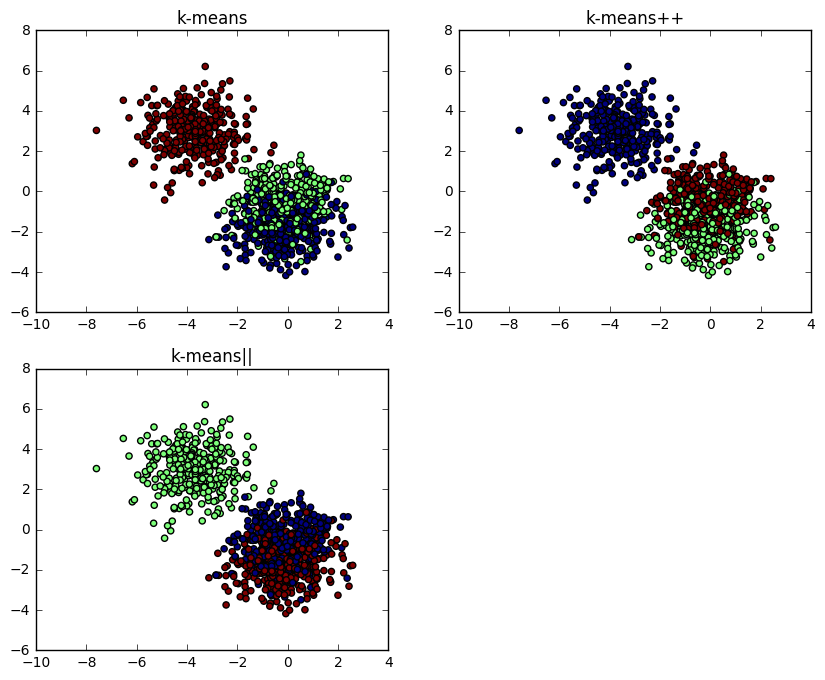

In [161]:
plt.figure(1,figsize=(10,8))
plt.subplot(221)
plt.scatter(Gaussian_Mixture_Data[:,0], Gaussian_Mixture_Data[:,1], c = rand)
plt.title("k-means")
plt.subplot(222)
plt.scatter(Gaussian_Mixture_Data[:,0], Gaussian_Mixture_Data[:,1], c = kmeanpp)
plt.title("k-means++")
plt.subplot(223)
plt.scatter(Gaussian_Mixture_Data[:,0], Gaussian_Mixture_Data[:,1], c = scal_kmeanpp)
plt.title("k-means||")
pass

Next, I plot the iris data. Again the final clustering is nearly identical across algorithms

In [164]:

random = np.array(iris_data)[np.random.choice(np.array(iris_data).shape[0],size = 3),]
kmeans_pp_centers = jit_k_means_pp(np.array(iris_data), 3)
scalable_kmeans_pp_centers = jit_scalable_k_means_pp(np.array(iris_data), 3,2)

rand = KMeans(n_clusters=3, init = random, n_init = 1).fit_predict(np.array(iris_data))
kmeanpp = KMeans(n_clusters=3,init = kmeans_pp_centers , n_init = 1).fit_predict(np.array(iris_data))
scal_kmeanpp = KMeans(n_clusters=3,init = scalable_kmeans_pp_centers,n_init=1).fit_predict( np.array(iris_data))

/opt/conda/lib/python3.5/site-packages/ipykernel/__main__.py:4: RuntimeWarning: invalid value encountered in true_divide


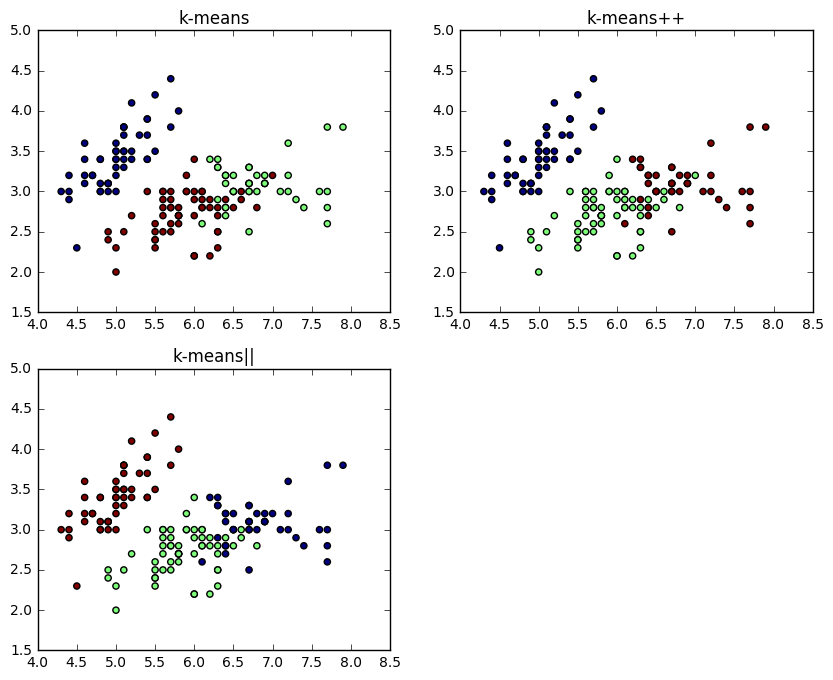

In [166]:
plt.figure(1,figsize=(10,8))
plt.subplot(221)
plt.scatter(np.array(iris_data)[:,0], np.array(iris_data)[:,1], c = rand)
plt.title("k-means")
plt.subplot(222)
plt.scatter(np.array(iris_data)[:,0], np.array(iris_data)[:,1], c = kmeanpp)
plt.title("k-means++")
plt.subplot(223)
plt.scatter(np.array(iris_data)[:,0], np.array(iris_data)[:,1], c = scal_kmeanpp)
plt.title("k-means||")
pass

Finally I plot the breast cancer clustering and find again that the final clusterings are very similar. This provides evidence that all algorithms arrive at the same final solution. However *means||* seems to pick a better initial clustering, which reduces the number of required Lloyd's iterations.

In [167]:
random = np.array(breast_cancer)[np.random.choice(np.array(breast_cancer).shape[0],size = 2),]
kmeans_pp_centers = jit_k_means_pp(np.array(breast_cancer), 2)
scalable_kmeans_pp_centers = jit_scalable_k_means_pp(np.array(breast_cancer), 2,2)

rand = KMeans(n_clusters=2, init = random, n_init = 1).fit_predict(np.array(breast_cancer))
kmeanpp = KMeans(n_clusters=2,init = kmeans_pp_centers , n_init = 1).fit_predict(np.array(breast_cancer))
scal_kmeanpp = KMeans(n_clusters=2,init = scalable_kmeans_pp_centers,n_init=1).fit_predict( np.array(breast_cancer))

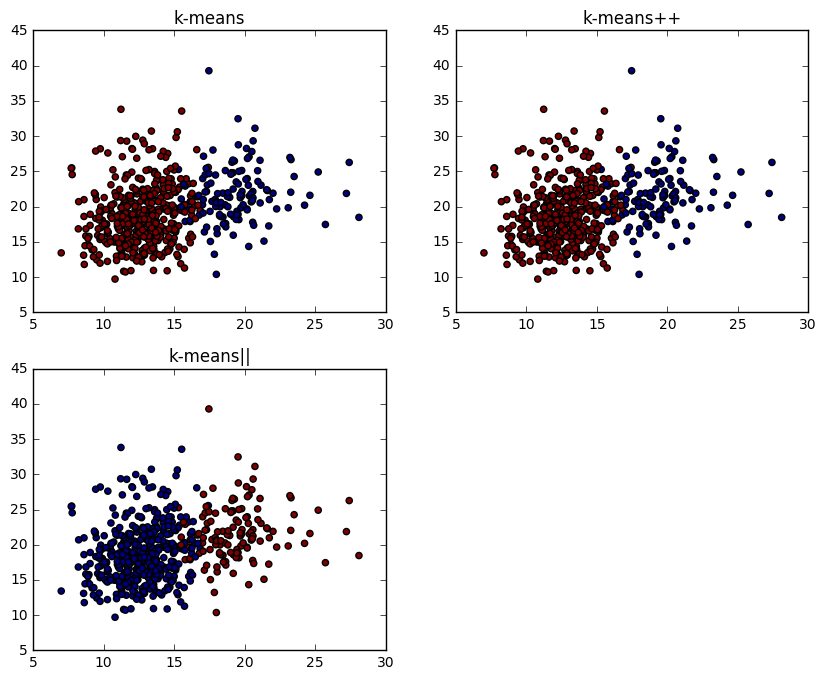

In [168]:
plt.figure(1,figsize=(10,8))
plt.subplot(221)
plt.scatter(np.array(breast_cancer)[:,0], np.array(breast_cancer)[:,1], c = rand)
plt.title("k-means")
plt.subplot(222)
plt.scatter(np.array(breast_cancer)[:,0], np.array(breast_cancer)[:,1], c = kmeanpp)
plt.title("k-means++")
plt.subplot(223)
plt.scatter(np.array(breast_cancer)[:,0], np.array(breast_cancer)[:,1], c = scal_kmeanpp)
plt.title("k-means||")
pass

### Section 6: Discussion and Conclusion

In this project, we implemented both *k-means++* and *k-means||* in Python. We optimized our code with JIT and Cython, which resulted in significant speed ups. We also implemented a parallel version of *kmeans||*. We then tested our functions on three datasets: the gaussian mixture, iris, and breast cancer datasets.

We compared running times of our functions and found that the JIT version was the fastest on all datasets. Unfortunately, our parallel implementation had very poor performance likely due to the limitations of GIL in python. Next, we varied the oversampling factor $\ell$ to see how it affected performance. Unsurprisingly, increasing $\ell$ increased the running time in all cases. 

We also compared both the initial clustering cost and the cost after Lloyd's iterations for *kmeans++*, *kmeans||*, and random centers. We found that *kmeans||* had by far the lowest initial cost but that all of the algoritms had similar final costs. Next, we compared the initial costs for different values of $\ell$. Unlike the original paper, we did not find that increasing $\ell$ sigificantly improved performance, perhaps because we have do not have large numbers of clusters. 

Future work should focus onimproving our parallel version of the *kmeans||* algorithm. Turning of the GIL in Cython or creating a MapReduce version in Spark could significantly improve performance. It would also be useful to test our functions on datasets with large numbers of clusters to see how they perform as the complexity of the data increases.

### Section 7: References

Bahmani, Bahman, Benjamin Moseley, Andrea Vattani, Ravi Kumar, and Sergei Vassilvitskii. "Scalable k-means++." Proceedings of the VLDB Endowment 5, no. 7 (2012): 622-633.

